In [290]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar
import os

In [291]:
folder_path = 'pdf'
pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]

In [292]:
all_pages = extract_pages(
    pdf_file='pdf/'+pdf_files[0],
    page_numbers=[5],
    maxpages=999
)

full_text = ""

for page_layout in all_pages:
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            for text_line in element:
                full_text += text_line.get_text()

In [315]:
full_text = full_text.strip()

In [294]:
full_text[:10]

'“Het is zo'

In [295]:
len(full_text)

3500

In [296]:
import spacy
from langdetect import detect
import pandas as pd

dutch_spacy_model = "nl_core_news_md"

nlp = spacy.load(dutch_spacy_model) if detect(full_text) == 'nl' else spacy.load("en_core_word_md")
doc = nlp(full_text)

sentences = []

for sentence in doc.sents:
    sentences.append(str(sentence))


In [297]:
df = pd.DataFrame(sentences, columns=['sentence'])

In [298]:
df.head()

,sentence
0,“Het is zoals leren fietsen waarbij VR de rol ...
1,"een goed hulpmiddel, maar \nlangzaamaan kan je..."
2,” \nPrototype 2 \nBeleving door de personen di...
3,Het meer interactieve 360°-scenario met bijkom...
4,De testpersoon die ook het eerste prototype te...


``Textstat`` biedt ook FOG en FRE berekeningen aan, maar de ``readability`` bibliotheek bevat meer functies voor leesbaarheidsformules. Het onderzoek en het prototype blijft bij deze bibliotheek. Daarnaast is het ook mogelijk om grammaticale constructies te bekijken.

In [299]:
def get_sentence_length(sentence):
    doc = nlp(sentence)
    return len(doc)

In [300]:
df['sentence_length'] = df['sentence'].apply(get_sentence_length)

In [301]:
df.head()

,sentence,sentence_length
0,“Het is zoals leren fietsen waarbij VR de rol ...,15
1,"een goed hulpmiddel, maar \nlangzaamaan kan je...",11
2,” \nPrototype 2 \nBeleving door de personen di...,12
3,Het meer interactieve 360°-scenario met bijkom...,17
4,De testpersoon die ook het eerste prototype te...,45


In [302]:
df = df[df['sentence_length'] > 3]

In [303]:
import readability

for key in readability.getmeasures("test")['readability grades'].keys():
    df[key] = df['sentence'].apply(lambda x: readability.getmeasures(x)['readability grades'][key])

In [304]:
df.head()

,sentence,sentence_length,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex
0,“Het is zoals leren fietsen waarbij VR de rol ...,15,4.003077,6.446154,8.608729,89.516923,8.276923,43.769231,8.477226,4.000000,18.856685
1,"een goed hulpmiddel, maar \nlangzaamaan kan je...",11,3.670000,5.886250,8.406575,75.875000,11.600000,29.000000,8.477226,1.000000,19.624900
2,” \nPrototype 2 \nBeleving door de personen di...,12,6.100000,5.808333,5.443147,56.078333,11.066667,52.666667,7.472136,1.333333,15.611267
3,Het meer interactieve 360°-scenario met bijkom...,17,14.111429,15.712857,21.971377,6.358571,22.800000,57.000000,13.246951,3.500000,17.517986
4,De testpersoon die ook het eerste prototype te...,45,4.950000,6.667167,8.733472,83.321667,10.333333,25.833333,10.071068,1.666667,18.114083


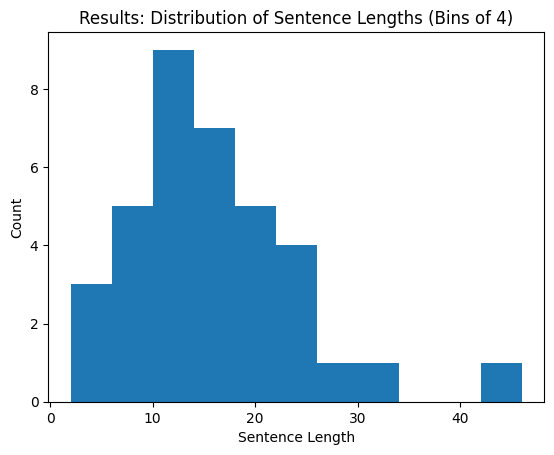

In [305]:
import matplotlib.pyplot as plt

bin_size = 4
df['bin_sentence'] = (df['sentence_length'] // bin_size) * bin_size

grouped = df.groupby('bin_sentence')['bin_sentence'].count().reset_index(name='count')

plt.bar(grouped['bin_sentence'], grouped['count'], width=bin_size)
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Results: Distribution of Sentence Lengths (Bins of 4)')
plt.show()

# Zinsconstructies.

In [306]:
word_usage_cols = readability.getmeasures("test")['word usage'].keys()
for key in word_usage_cols:
    df[key] = df['sentence'].apply(lambda x: readability.getmeasures(x, lang='nl')['word usage'][key])

In [307]:
sentence_beginnings_cols = readability.getmeasures("test")['sentence beginnings'].keys()
for key in sentence_beginnings_cols:
    df[key] = df['sentence'].apply(lambda x: readability.getmeasures(x, lang='nl')['sentence beginnings'][key])

In [308]:
df.head(4)

,sentence,sentence_length,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,...,bin_sentence,tobeverb,auxverb,conjunction,pronoun,preposition,nominalization,interrogative,article,subordination
0,“Het is zoals leren fietsen waarbij VR de rol ...,15,4.003077,6.446154,8.608729,89.516923,8.276923,43.769231,8.477226,4.000000,...,12,1,0,0,0,0,0,0,0,0
1,"een goed hulpmiddel, maar \nlangzaamaan kan je...",11,3.670000,5.886250,8.406575,75.875000,11.600000,29.000000,8.477226,1.000000,...,8,0,1,0,0,0,0,0,1,0
2,” \nPrototype 2 \nBeleving door de personen di...,12,6.100000,5.808333,5.443147,56.078333,11.066667,52.666667,7.472136,1.333333,...,12,0,0,0,0,0,1,0,0,0
3,Het meer interactieve 360°-scenario met bijkom...,17,14.111429,15.712857,21.971377,6.358571,22.800000,57.000000,13.246951,3.500000,...,16,0,1,0,1,0,1,0,1,0


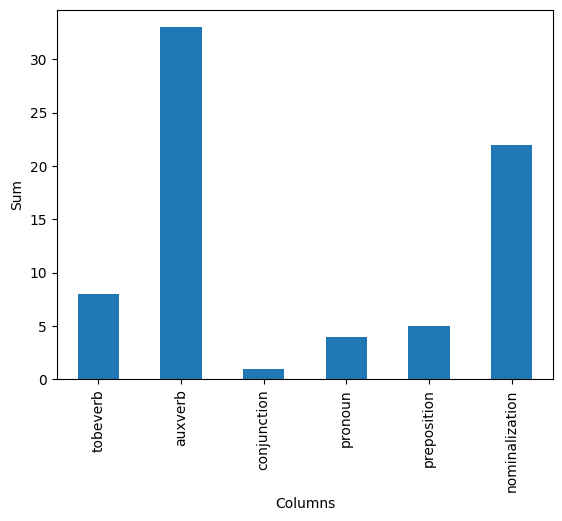

In [314]:
word_usage_sum = df[word_usage_cols].sum()
word_usage_sum.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.show()

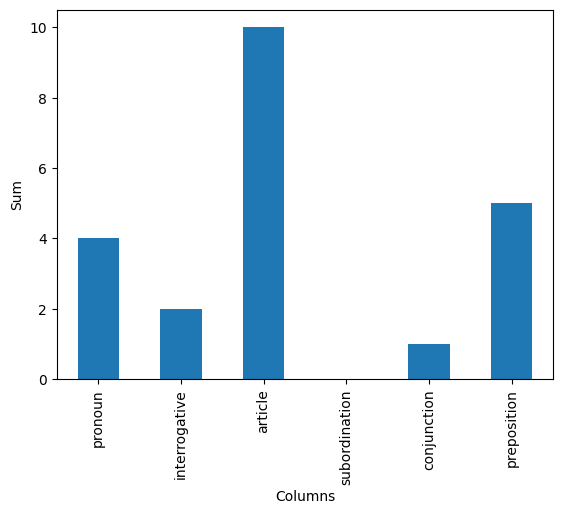

In [313]:
sentence_beginnings_sum = df[sentence_beginnings_cols].sum()
sentence_beginnings_sum.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.show()